In [1]:
import pandas as pd
import json
import glob

from matplotlib import pyplot as plt
from utils import get_holidays, is_christmas, is_covid, is_in_lecture_free, is_summer_semester, is_winter_semester

In [2]:
weather_df = pd.read_csv("data/weather.csv")

In [3]:
useless_columns = [
    "dt", "timezone", "city_name", "lat", "lon", "visibility",
    "sea_level", "rain_3h", "snow_3h", "weather_id", "weather_main",
    "weather_description", "weather_icon", "grnd_level", "clouds_all",
    "dew_point", "feels_like", "wind_gust", # this data is not provided by API for future

]

# convert dates to strings
weather_df["dt_iso"] = weather_df["dt_iso"].apply(lambda line: line.split()[0])

# process data about precipitation
weather_df.loc[weather_df["rain_1h"].isna(), "rain_1h"] = 0.0
weather_df.loc[weather_df["snow_1h"].isna(), "snow_1h"] = 0.0
weather_df.loc[weather_df["wind_gust"].isna(), "wind_gust"] = 0.0

# drop useless data
weather_df.drop(columns=useless_columns, inplace=True)

In [4]:
# aggregation
weather_df = weather_df.groupby(
    by="dt_iso",
).agg(
    {
        "temp": "mean",
        "temp_min": "min",
        "temp_max": "max",
        "pressure": "mean",
        "humidity": "mean",
        "wind_speed": "mean",
        "wind_deg": "mean",
        "rain_1h": "sum",
        "snow_1h": "sum",
    }
)

weather_df["precipitation"] = weather_df["rain_1h"] + weather_df["snow_1h"]
weather_df.drop(columns=["rain_1h", "snow_1h"], inplace=True)

weather_df = weather_df.round(decimals=2)
weather_df.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,precipitation
dt_iso,,,,,,,,
2017-01-01,-4.50,-7.47,-0.77,1024.12,88.08,2.40,208.62,0.00
2017-01-02,-2.02,-6.48,-0.32,1021.71,97.12,3.34,263.46,3.16
2017-01-03,-0.63,-2.69,1.30,1023.96,95.12,5.29,252.08,2.83
2017-01-04,0.26,-1.73,2.39,1011.83,93.50,6.84,270.38,8.10
2017-01-05,-3.96,-10.80,0.54,1027.21,80.00,4.39,188.88,1.33


In [5]:
# read sales data
sales_df = pd.read_csv("data/daily_data.csv", index_col=0)
sales_df.head()

,Target Coffee,Target Milk Coffee,Target Cocoa,Target Tee,Target Coffee Time,Student Price Coffee,Worker Price Coffee,Guest Price Coffee,Student Price Milk Coffee,Worker Price Milk Coffee,...,x0_December,x0_February,x0_January,x0_July,x0_June,x0_March,x0_May,x0_November,x0_October,x0_September
2017-01-09,419.0,93.0,26.0,101.0,105.0,0.94,0.84,0.84,1.36,1.31,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-10,446.0,83.0,31.0,83.0,110.0,0.91,0.87,0.94,1.42,1.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11,451.0,111.0,25.0,121.0,99.0,0.92,1.01,1.12,1.40,1.31,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-12,411.0,97.0,29.0,92.0,126.0,0.94,0.91,0.84,1.42,1.44,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-13,289.0,73.0,24.0,87.0,45.0,0.92,0.84,0.84,1.40,1.31,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# join them
merged_df = pd.merge(sales_df, weather_df, left_index=True, right_index=True, how="inner")
merged_df.head()

,Target Coffee,Target Milk Coffee,Target Cocoa,Target Tee,Target Coffee Time,Student Price Coffee,Worker Price Coffee,Guest Price Coffee,Student Price Milk Coffee,Worker Price Milk Coffee,...,x0_October,x0_September,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,precipitation
2017-01-09,419.0,93.0,26.0,101.0,105.0,0.94,0.84,0.84,1.36,1.31,...,0.0,0.0,-1.44,-3.48,-0.32,1027.42,93.46,1.70,223.88,0.00
2017-01-10,446.0,83.0,31.0,83.0,110.0,0.91,0.87,0.94,1.42,1.50,...,0.0,0.0,-3.18,-9.58,-1.22,1015.62,84.75,2.73,147.58,0.00
2017-01-11,451.0,111.0,25.0,121.0,99.0,0.92,1.01,1.12,1.40,1.31,...,0.0,0.0,-4.45,-8.57,2.83,1012.58,91.79,4.24,196.71,5.72
2017-01-12,411.0,97.0,29.0,92.0,126.0,0.94,0.91,0.84,1.42,1.44,...,0.0,0.0,2.54,0.50,4.52,1009.08,88.75,5.12,235.21,3.84
2017-01-13,289.0,73.0,24.0,87.0,45.0,0.92,0.84,0.84,1.40,1.31,...,0.0,0.0,1.40,-1.91,4.06,998.12,87.29,7.29,245.04,7.71


In [7]:
merged_df.to_csv("data/extended_data.csv")

# Data About Public Holidays (University closed)

In [11]:
files = glob.glob("data/holidays/*.json")

In [12]:
holidays = list()

for file_name in files:
    with open(file_name, "r") as file:
        data = json.loads(file.read())
        data = data["response"]["holidays"]

    holidays += get_holidays(data)

holidays = pd.DataFrame(data={"Holidays": sorted(holidays)})

# concatenate them
holidays.sort_values(by="Holidays", inplace=True)

In [18]:
holidays.to_csv("data/holidays.csv")

# Add a new feature - is_holiday

In [19]:
df = pd.read_csv("data/extended_data.csv", index_col=0)
holidays = pd.read_csv("data/holidays.csv", index_col=0)

In [20]:
holidays = list(holidays["Holidays"])

df["is_holiday"] = df.index.map(
    lambda elem: float(is_christmas(elem) or elem in holidays)
)
df["is_lecture_free"] = df.index.map(is_in_lecture_free)
df["is_covid"] = df.index.map(is_covid)
df["is_winter"] = df.index.map(is_winter_semester)
df["is_summer"] = df.index.map(is_summer_semester)

In [21]:
df.to_csv("data/extended_data.csv")

# Decomposition

In [30]:
df = pd.read_csv("data/extended_data.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  [
    "Target Coffee", "Target Milk Coffee", "Target Cocoa", "Target Tee", "Target Coffee Time",
    "temp"
]

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

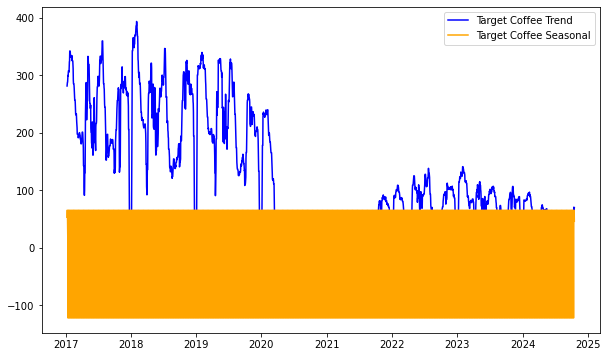

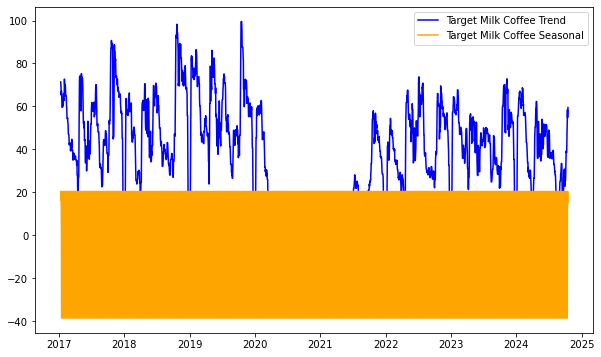

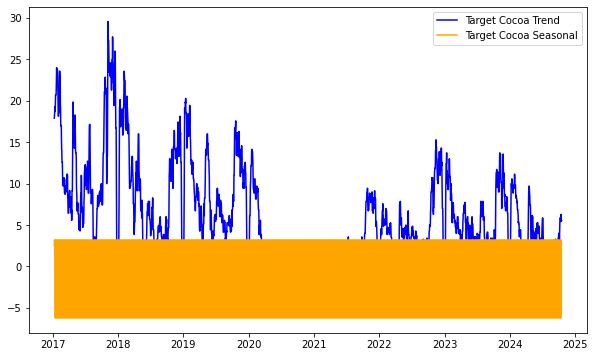

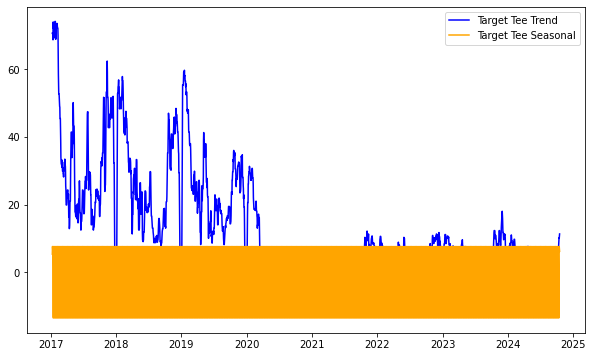

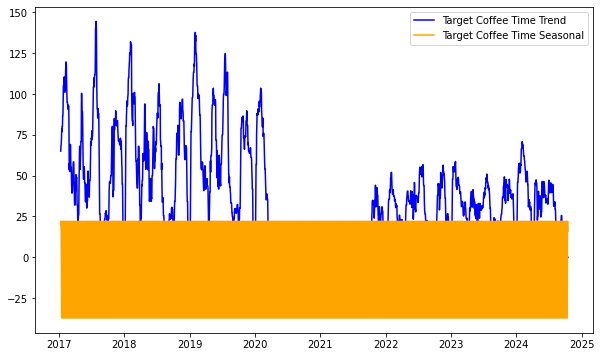

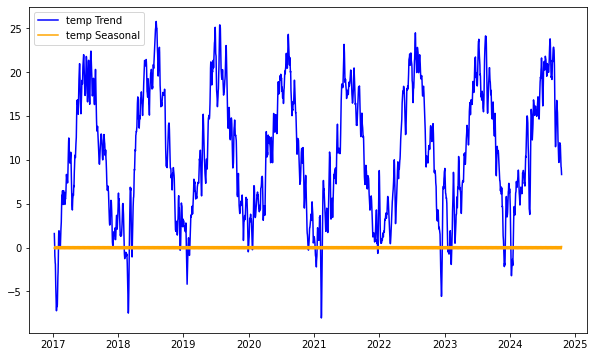

In [33]:
for col in decompose_cols:
    plt.figure(figsize=(10, 6))
    plt.plot(df[f"{col}_trend"], color="blue", label=f"{col} Trend")
    plt.plot(df[f"{col}_seasonal"], color="orange", label=f"{col} Seasonal")
    plt.legend()
    plt.show()

In [34]:
df.to_csv("data/seasonal_data.csv")